k-meansクラスタリングによる画像減色

In [11]:
#coding:utf-8

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from collections import namedtuple
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image

In [3]:
def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

In [4]:
def calc_centroid(vecs):
    """do not care about ZeroDevisionError
    """
    g,b,r = 0,0,0
    for v in vecs:
        g+=v[0][0]
        b+=v[0][1]
        r+=v[0][2]
    g/=len(vecs)
    b/=len(vecs)
    r/=len(vecs)
    return (int(round(g)),int(round(b)),int(round(r)))

In [5]:
def rgb2hex(centroids):
    """gbr->color_code of rgb
    """
    hex_color_code = []
    for v in centroids:
        tmp = []
        hex_code = ""
        for e in v:
            if e<16:
                h = "0"+str(hex(e))[2:]
            else:
                h = str(hex(e))[2:]
            tmp.append(h)
        hex_code = tmp[2]+tmp[1]+tmp[0]
        hex_color_code.append("#"+hex_code)
    return hex_color_code

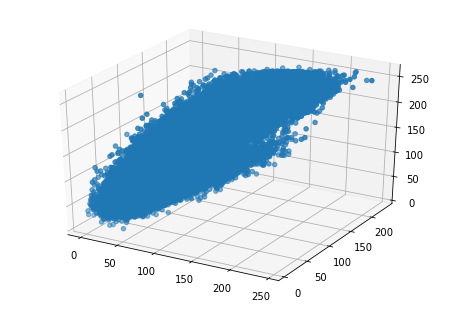

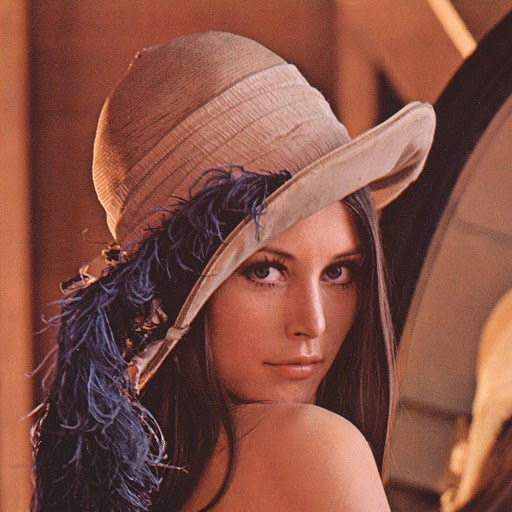

In [9]:
#特徴ベクトルの型の定義
vec = namedtuple('vec_info',['GBR','coordinate'])

#画像を読み込み
img = cv2.imread("lenna.jpg")
    
#画像のサイズ
height = img.shape[0]
width  = img.shape[1]

#特徴ベクトルの総数(画素数)
num_vec = height*width

#各画素の特徴ベクトルを取得する
vectors = []
for y in range(height):
    for x in range(width):
        BGR = img[y,x]
        v = vec(BGR,(y,x))
        vectors.append(v)
vectors = np.array(vectors)
feature_vectors = vectors[:,0]

tmp = []
for vec in feature_vectors:
    tmp.append(vec)
feature_vectors = np.array(list(tmp))

#特徴空間の点をプロット
feature_vectors_G = feature_vectors[:,0]
feature_vectors_B = feature_vectors[:,1]
feature_vectors_R = feature_vectors[:,2]

#初期プロットの表示
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(feature_vectors_G,feature_vectors_B,feature_vectors_R)
plt.show()

#初期画像表示
display_cv_image(img,'.jpg')

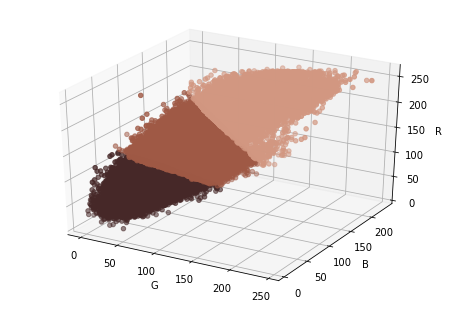

In [13]:
#クラスタの個数
num_cluster = 3
#k-means法
km = KMeans(n_clusters=num_cluster,#クラスタ数
            init='random',#セントロイドの初期値をランダムに選択
            n_init=10,#異なるセントロイドの初期値を用いたk-meansアルゴリズム
            max_iter=100,#k-meansアルゴリズムの内部イテレーション回数
            tol=1e-04,#収束と判定するための相対的な許容誤差
            random_state=0#セントロイドの初期値に用いる乱数生成器の状態
            )
y_km = km.fit_predict(feature_vectors)#y_kmにクラスタの番号が保存される

#クラス毎に分類する
#vectorsとfeature_vectorsとy_kmは互いに添字が一致
CLUSTER = [[] for _ in range(num_cluster)]
for i,v in enumerate(vectors):
    for which_cluster in range(num_cluster):
        if y_km[i] == which_cluster:
            CLUSTER[which_cluster].append(v)
    
#セントロイドを求める
centroids = [[] for _ in range(len(CLUSTER))]
for i,vecs in enumerate(CLUSTER):
    centroids[i] = calc_centroid(vecs)

#セントロイドを16進数コードに変換する
COLOR = rgb2hex(centroids)

#クラス毎にプロットする
CLUSTER_COLOR = [[[],[],[]] for _ in range(num_cluster)]
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('G')
ax.set_ylabel('B')
ax.set_zlabel('R')
for i,vecs in enumerate(CLUSTER):
    for j,v in enumerate(vecs):
        CLUSTER_COLOR[i][0].append(v[0][0])
        CLUSTER_COLOR[i][1].append(v[0][1])
        CLUSTER_COLOR[i][2].append(v[0][2])
    for k in range(3):
        CLUSTER_COLOR[i][k] = np.array(CLUSTER_COLOR[i][k])
for i in range(len(CLUSTER_COLOR)):
    ax.scatter(CLUSTER_COLOR[i][0],CLUSTER_COLOR[i][1],CLUSTER_COLOR[i][2],c=COLOR[i])
plt.show()

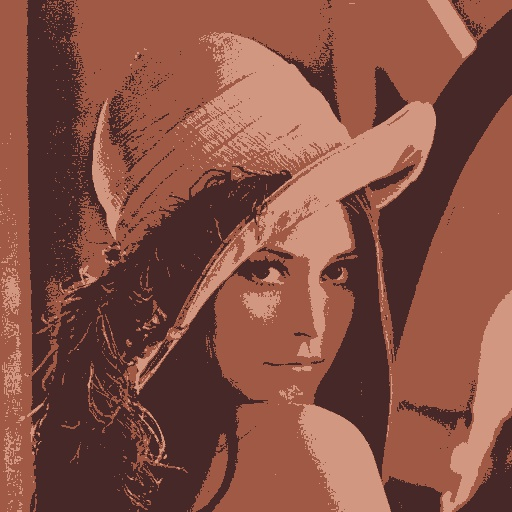

True

In [14]:
#画像を変換していく
for i,vecs in enumerate(CLUSTER):
    for j,v in enumerate(vecs):
        img[v[1][0],v[1][1]] = centroids[i]
    
#変換後の画像を表示
display_cv_image(img,'.jpg')

#画像を出力
file_name = "res_"+str(len(CLUSTER))
cv2.imwrite(file_name+".jpg",img)